In [8]:
from pathlib import Path
import PyQt5
import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
from IPython.display import Markdown, display
from PIL import Image
from transformers import pipeline, AutoTokenizer
from optimum.intel.openvino import OVModelForSeq2SeqLM, OVModelForSequenceClassification
import re
import transformers
from diff_match_patch import diff_match_patch# 문자열 바뀐 부분 확인
# from notebook_utils import load_image

# @최초 input

In [9]:
image = cv2.imread("_input/sample_letter.jpg")

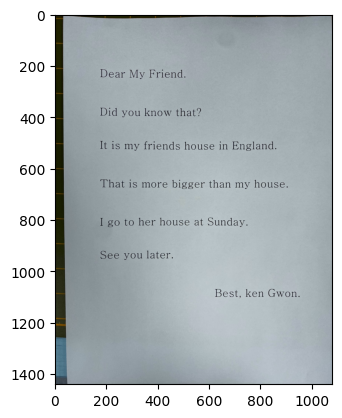

In [10]:
plt.imshow(image)

# @권강현 - part1. OCR 담당
- input: 이미지.jpg
- output: python String class

In [11]:
def multiply_by_ratio(ratio_x, ratio_y, box):
    return [
        max(shape * ratio_y, 10) if idx % 2 else shape * ratio_x
        for idx, shape in enumerate(box[:-1])
    ]


def run_preprocesing_on_crop(crop, net_shape):
    temp_img = cv2.resize(crop, net_shape)
    temp_img = temp_img.reshape((1,) * 2 + temp_img.shape)
    return temp_img


def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.2, conf_labels=True):
    # RGB값의 코드 가독성을 높이기 위한 dictionary 선언
    colors = {"red": (255, 0, 0), "green": (0, 255, 0), "white": (255, 255, 255)}

    # resize 비율 계산
    (real_y, real_x), (resized_y, resized_x) = bgr_image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # 이미지를 출력하기 위한 바탕 이미지 변수 선언
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    for box, annotation in boxes:
        conf = box[-1] # confidence값은 모델 output의 마지막 요소값이다.

        if conf > threshold:             
            (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, box))
            cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3) 

            if conf_labels: 
                cv2.putText(
                    rgb_image,
                    f"{annotation}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image



# 모델 준비
model_dir = Path("model")
precision = "FP16"
detection_model = "horizontal-text-detection-0001"
recognition_model = "text-recognition-resnet-fc"
detection_model_path = (model_dir / "intel/horizontal-text-detection-0001" / precision / detection_model).with_suffix(".xml")
recognition_model_path = (model_dir / "public/text-recognition-resnet-fc" / precision / recognition_model).with_suffix(".xml")

# 텍스트 detection 모델 생성
core = ov.Core()
detection_model = core.read_model(model=detection_model_path, weights=detection_model_path.with_suffix(".bin"))
detection_compiled_model = core.compile_model(model=detection_model, device_name='AUTO')

# 텍스트 detection 모델의 input shape에 맞게 이미지 transform 준비
detection_input_layer = detection_compiled_model.input(0)
N, C, H, W = detection_input_layer.shape
# image = cv2.imread("_input/sample_letter.jpg")
resized_image = cv2.resize(image, (W, H))
(real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

# 텍스트 detection 모델 추론
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)
output_key = detection_compiled_model.output("boxes")
boxes = detection_compiled_model([input_image])[output_key]
boxes = boxes[~np.all(boxes == 0, axis=1)] # 내용이 0뿐인 박스는 제거


# 텍스트 recognition 모델 생성
recognition_model = core.read_model(model=recognition_model_path, weights=recognition_model_path.with_suffix(".bin"))
recognition_compiled_model = core.compile_model(model=recognition_model, device_name='AUTO')

# 텍스트 recognition 모델의 input shape에 맞게 이미지 transform 준비
recognition_output_layer = recognition_compiled_model.output(0)
recognition_input_layer = recognition_compiled_model.input(0)
_, _, H, W = recognition_input_layer.shape


grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# "text-recognition-resnet-fc" 모델이 제공하는 encode output 문자열은 다음과 같음(나머지 문자열은 지원하지 않음)
letters = "~0123456789abcdefghijklmnopqrstuvwxyz"

annotations = list()
cropped_images = list()

for i, crop in enumerate(boxes):
    # Get coordinates on corners of a crop.
    (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, crop))
    image_crop = run_preprocesing_on_crop(grayscale_image[y_min:y_max, x_min:x_max], (W, H))

    # Run inference with the recognition model.
    result = recognition_compiled_model([image_crop])[recognition_output_layer]

    # Squeeze the output to remove unnecessary dimension.
    recognition_results_test = np.squeeze(result)

    # Read an annotation based on probabilities from the output layer.
    annotation = list()
    for letter in recognition_results_test:
        parsed_letter = letters[letter.argmax()]

        # Returning 0 index from `argmax` signalizes an end of a string.
        if parsed_letter == letters[0]:
            break
        annotation.append(parsed_letter)
    annotations.append("".join(annotation))
    cropped_image = Image.fromarray(image[y_min:y_max, x_min:x_max])
    cropped_images.append(cropped_image)

boxes_with_annotations = list(zip(boxes, annotations))

ocr_text_result = [
    annotation
    for _, annotation in sorted(zip(boxes, annotations), key=lambda x: x[0][0] ** 2 + x[0][1] ** 2)
]

result_string = ' '.join(ocr_text_result)

dear did my you friend it is know my friends that that is more i house go to bigger her see house in you than later england at sunday my house best ken gwon


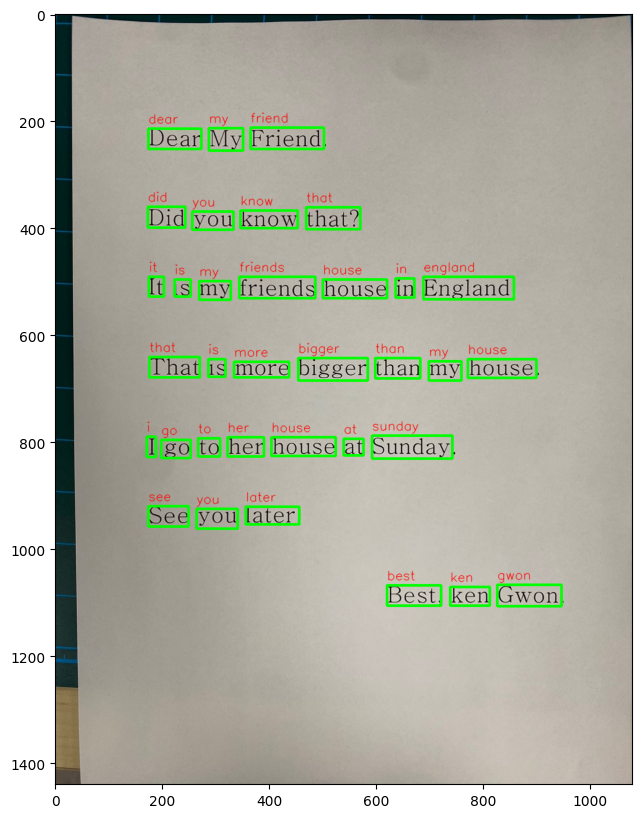

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(convert_result_to_image(image, resized_image, boxes_with_annotations, conf_labels=True))
print(result_string)

# @홍종현 - part2. Grammer Check 담당
- input: python String class
- output: python String class

In [13]:
grammar_checker_model_id = "textattack/roberta-base-CoLA"
grammar_checker_dir = Path("model/roberta-base-cola")
grammar_checker_tokenizer = AutoTokenizer.from_pretrained(grammar_checker_model_id)
grammar_checker_model = OVModelForSequenceClassification.from_pretrained(grammar_checker_dir, device='AUTO')

grammar_checker_pipe = pipeline("text-classification", model=grammar_checker_model, tokenizer=grammar_checker_tokenizer)


grammar_corrector_model_id = "pszemraj/flan-t5-large-grammar-synthesis"
grammar_corrector_dir = Path("model/flan-t5-large-grammar-synthesis")
grammar_corrector_tokenizer = AutoTokenizer.from_pretrained(grammar_corrector_model_id)
grammar_corrector_model = OVModelForSeq2SeqLM.from_pretrained(grammar_corrector_dir, device='AUTO')
    
grammar_corrector_pipe = pipeline("text2text-generation", model=grammar_corrector_model, tokenizer=grammar_corrector_tokenizer)

Compiling the model to AUTO ...
Setting OpenVINO CACHE_DIR to model/roberta-base-cola/model_cache
Compiling the encoder to AUTO ...
Compiling the decoder to AUTO ...
Compiling the decoder to AUTO ...


In [16]:
## 문자열 분할
# text: 문장 배치로 분할할 텍스트, list: 문장 배치 목록
def split_text(text: str) -> list:
   
    # 정규식을 사용하여 텍스트를 문장으로 분할
    sentences = re.split(r"(?<=[^A-Z].[.?]) +(?=[A-Z])", text)
    # 문장 배치
    sentence_batches = []
    # 임시 문장 배치 저장
    temp_batch = []

    for sentence in sentences:
        # 임시 문장 배치 추가
        temp_batch.append(sentence)

        # 임시 문장 2~3문장 사이 OR 마지막 배치인 경우
        if len(temp_batch) >= 2 and len(temp_batch) <= 3 or sentence == sentences[-1]:
            # 문장 배치 추가
            sentence_batches.append(temp_batch)
            temp_batch = []

    return sentence_batches


## 문자열 문법 수정
# text: 수정할 텍스트, checker: 텍스트의 문법 품질 확인 파이프라인, corrector: 텍스트 수정 파이프라인, separator: 수정된 텍스트를 단일 문자열로 결합할때 사용할 구분기호(기본값은 공백문자)
def correct_text(text: str, checker: transformers.pipelines.Pipeline, corrector: transformers.pipelines.Pipeline, separator: str = " ") -> str:
    
    # 문장 배치로 분할된 텍스트
    sentence_batches = split_text(text)
    
    # 수정된 텍스트
    corrected_text = []

    # 문장 반복 및 진행도 출력
    for batch in sentence_batches:
        # 배치 문장을 단일 문자열로 결합
        raw_text = " ".join(batch)

        # 텍스트 분류 파이프라인 사용 -> 텍스트 문법 품질 확인(label, score)
        results = checker(raw_text)
        
        # 텍스트 분류 결과가 LABEL_1이 아니거나 점수가 0.9 미만인 LABEL_1인 경우일때
        if results[0]["label"] != "LABEL_1" or (
            results[0]["label"] == "LABEL_1" and results[0]["score"] < 0.9
        ):
            # 텍스트 생성 파이프라인 사용하여 텍스트 수정
            corrected_batch = corrector(raw_text)
            corrected_text.append(corrected_batch[0]["generated_text"])
        else:
            corrected_text.append(raw_text)

    # 수정된 텍스트를 단일 문자열로 결합
    corrected_text = separator.join(corrected_text)
    return corrected_text

# 문법 교정 문자열 선언 및 초기화
check_text = result_string
corrected_text = correct_text(check_text, grammar_checker_pipe, grammar_corrector_pipe)



before = check_text
after = corrected_text
temp = "" 
dmp = diff_match_patch()
diff = dmp.diff_main(before, after)
dmp.diff_cleanupSemantic(diff)

#  0: 수정된 부분이 없을때
#  1: 추가
# -1: 삭제
for d in diff:
    if d[0] == 1:
        temp += ("[+\'"+d[1]+"\']")
    elif d[0] == 0:
        temp += (d[1])
    elif d[0] == -1:
        temp += ("[-\'"+d[1]+"\']")

# 텍스트 파일에 문자열 저장
with open('_output/grammercheck_text.txt', 'w') as file:
    file.write(corrected_text)

In [15]:
# 문자열 출력 (입력 문자열, 문법 교정 문자열)
print(f"input text: {check_text}\n")
print(f'generated text: {corrected_text}\n')
print(f"compare text: {temp}")

input text: dear did my you friend it is know my friends that that is more i house go to bigger her see house in you than later england at sunday my house best ken gwon

generated text: Do you know my friend that it is more important to go to her house in London than to go to my house in Beijing on a Sunday?

compare text: [-'dear did my you friend it is'][+'Do you'] know my friend[-'s'] that [-'tha'][+'i']t is more i[-' house go to bigger her see house in you than later england at sunday my house best ken gwon'][+'mportant to go to her house in London than to go to my house in Beijing on a Sunday?']


# @김진완 - part3. image Generation 담당
- input: python String class
- output: 이미지.jpg

In [9]:
## 1. PyTorch Models pipeline 만들기

from diffusers import StableDiffusionPipeline
from IPython.display import display 
import gc
# 라이브러리 임포트: 필요한 모듈을 가져오는 부분으로, diffusers 라이브러리에서 StableDiffusionPipeline 클래스와 gc (가비지 컬렉션) 모듈을 가져옵니다.

pipe = StableDiffusionPipeline.from_pretrained("prompthero/openjourney").to("cpu")
# 파이프라인 생성 및 설정: StableDiffusionPipeline의 사전 훈련된 모델 ("prompthero/openjourney")로부터 인스턴스를 생성하고, 파이프라인을 CPU로 이동합니다. to("cpu") 메서드는 모델이 CPU에 배치되도록 하는 데 사용됩니다.

text_encoder = pipe.text_encoder
text_encoder.eval()
unet = pipe.unet
unet.eval()
vae = pipe.vae
vae.eval()
# 구성 요소 추출: 파이프라인에서 구성 요소 (text_encoder, unet, vae)를 추출하고, eval() 메서드를 사용하여 이를 평가 모드로 설정합니다. 모델을 평가 모드로 설정하는 것은 학습이 완료되었거나 예측을 수행할 때 사용되며, 드롭아웃과 같은 작업을 비활성화합니다.

del pipe
gc.collect()
# 파이프라인 삭제 및 가비지 컬렉션: pipe 객체를 삭제하고 gc.collect()를 사용하여 가비지 컬렉션을 수행합니다. 이는 더 이상 필요하지 않은 파이프라인 객체에 의해 차지된 메모리를 해제하기 위한 것입니다.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


29

In [10]:
## 2. Text Encoder (텍스트 전달)

from pathlib import Path
import torch
import openvino as ov
TEXT_ENCODER_OV_PATH = Path("model/text_encoder.xml")
def cleanup_torchscript_cache():
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()  
# cleanup_torchscript_cache 함수: 이 함수는 TorchScript 캐시를 정리하는데 사용됩니다. 모델 변환 전에 TorchScript 캐시를 지우는 것은 변환 과정에서 문제가 발생할 수 있는 이슈를 방지합니다.
 
def convert_encoder(text_encoder: torch.nn.Module, ir_path:Path):
    input_ids = torch.ones((1, 77), dtype=torch.long)
    # switch model to inference mode
    text_encoder.eval()
    # 메모리 사용량을 줄이기 위해 그래디언트 계산 사용 안 함
    with torch.no_grad():
        # 모델을 추론 모드로 전환
        ov_model = ov.convert_model(text_encoder, example_input=input_ids, input=[(1,77),])
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    print(f'Text Encoder successfully converted to IR and saved to {ir_path}')
# convert_encoder 함수: 이 함수는 주어진 텍스트 인코더 모델을 OpenVINO IR 형식으로 변환합니다. 변환된 모델은 지정된 경로에 저장됩니다.

if not TEXT_ENCODER_OV_PATH.exists():
    convert_encoder(text_encoder, TEXT_ENCODER_OV_PATH)
else:
    print(f"Text encoder will be loaded from {TEXT_ENCODER_OV_PATH}")
# 변환 여부 확인 및 실행: 변환된 모델 파일이 존재하지 않으면 convert_encoder 함수를 호출하여 모델을 변환하고 저장합니다. 이미 변환된 모델 파일이 존재하면 해당 경로에서 모델을 로드합니다.

del text_encoder
gc.collect()
# 메모리 정리: 마지막으로, 텍스트 인코더 모델을 삭제하고 가비지 컬렉션을 수행하여 메모리를 정리합니다.

/home/hong/openvino/.openvino_env/lib/python3.10/site-packages/transformers/modeling_attn_mask_utils.py:66: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if input_shape[-1] > 1 or self.sliding_window is not None:
/home/hong/openvino/.openvino_env/lib/python3.10/site-packages/transformers/modeling_attn_mask_utils.py:137: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if past_key_values_length > 0:
/home/hong/openvino/.openvino_env/lib/python3.10/site-packages/transformers/models/clip/modeling_clip.py:273: TracerWarning: Converting a tensor to a Python bo

Text Encoder successfully converted to IR and saved to model/text_encoder.xml


4053

In [11]:
## 3. U-net : PyTorch 모델인 U-net을 OpenVINO (Open Visual Inference and Neural Network Optimization) 모델로 변환하는 과정을 수행합니다.

import numpy as np

UNET_OV_PATH = Path('model/unet.xml')

dtype_mapping = {
    torch.float32: ov.Type.f32,
    torch.float64: ov.Type.f64
}
# dtype_mapping 딕셔너리: PyTorch의 dtype과 OpenVINO의 dtype 간의 매핑을 제공하는 딕셔너리입니다. 예를 들어, torch.float32는 ov.Type.f32로 매핑됩니다.

def convert_unet(unet:torch.nn.Module, ir_path:Path):
    # prepare inputs
    encoder_hidden_state = torch.ones((2, 77, 768))
    latents_shape = (2, 4, 512 // 8, 512 // 8)
    latents = torch.randn(latents_shape)
    t = torch.from_numpy(np.array(1, dtype=float))
    dummy_inputs = (latents, t, encoder_hidden_state)
    input_info = []
    for input_tensor in dummy_inputs:
        shape = ov.PartialShape(tuple(input_tensor.shape))
        element_type = dtype_mapping[input_tensor.dtype]
        input_info.append((shape, element_type))

    unet.eval()
    with torch.no_grad():
        ov_model = ov.convert_model(unet, example_input=dummy_inputs, input=input_info)
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    print(f'Unet successfully converted to IR and saved to {ir_path}')
# convert_unet 함수: 이 함수는 주어진 U-net 모델을 OpenVINO IR 형식으로 변환합니다. 변환된 모델은 지정된 경로에 저장됩니다. 이 때, 예제 입력 (dummy_inputs)과 입력 정보 (input_info)를 사용하여 모델을 변환합니다.

if not UNET_OV_PATH.exists():
    convert_unet(unet, UNET_OV_PATH)
    gc.collect()
else:
    print(f"Unet will be loaded from {UNET_OV_PATH}")
# 변환 여부 확인 및 실행: 변환된 모델 파일이 존재하지 않으면 convert_unet 함수를 호출하여 모델을 변환하고 저장합니다. 이미 변환된 모델 파일이 존재하면 해당 경로에서 모델을 로드합니다.
del unet
gc.collect()

/home/hong/openvino/.openvino_env/lib/python3.10/site-packages/diffusers/models/unet_2d_condition.py:878: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if dim % default_overall_up_factor != 0:
/home/hong/openvino/.openvino_env/lib/python3.10/site-packages/diffusers/models/resnet.py:265: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert hidden_states.shape[1] == self.channels
/home/hong/openvino/.openvino_env/lib/python3.10/site-packages/diffusers/models/resnet.py:271: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be

Unet successfully converted to IR and saved to model/unet.xml


0

In [12]:
## 4. VAE : VAE(Variational Autoencoder) 모델을 인코딩과 디코딩을 위해 OpenVINO 모델로 변환하는 과정을 다룹니다.
VAE_ENCODER_OV_PATH = Path("model/vae_encoder.xml")

def convert_vae_encoder(vae: torch.nn.Module, ir_path: Path):
    class VAEEncoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, image):
            return self.vae.encode(x=image)["latent_dist"].sample()
    vae_encoder = VAEEncoderWrapper(vae)
    vae_encoder.eval()
    image = torch.zeros((1, 3, 512, 512))
    with torch.no_grad():
        ov_model = ov.convert_model(vae_encoder, example_input=image, input=[((1,3,512,512),)])
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    print(f'VAE encoder successfully converted to IR and saved to {ir_path}')
# convert_vae_encoder 함수: 이 함수는 주어진 VAE 모델을 OpenVINO IR 형식으로 변환합니다. 변환된 모델은 지정된 경로에 저장됩니다. 인코더를 변환하는 데에는 VAEEncoderWrapper 클래스를 사용하여 인코딩 부분만을 추출하고 이를 변환합니다.

if not VAE_ENCODER_OV_PATH.exists():
    convert_vae_encoder(vae, VAE_ENCODER_OV_PATH)
else:
    print(f"VAE encoder will be loaded from {VAE_ENCODER_OV_PATH}")

VAE_DECODER_OV_PATH = Path('model/vae_decoder.xml')

def convert_vae_decoder(vae: torch.nn.Module, ir_path: Path):
    class VAEDecoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, latents):
            return self.vae.decode(latents)
    
    vae_decoder = VAEDecoderWrapper(vae)
    latents = torch.zeros((1, 4, 64, 64))

    vae_decoder.eval()
    with torch.no_grad():
        ov_model = ov.convert_model(vae_decoder, example_input=latents, input=[((1,4,64,64),)])
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    print(f'VAE decoder successfully converted to IR and saved to {ir_path}')
# convert_vae_decoder 함수: 이 함수는 주어진 VAE 모델을 OpenVINO IR 형식으로 변환합니다. 변환된 모델은 지정된 경로에 저장됩니다. 디코더를 변환하는 데에는 VAEDecoderWrapper 클래스를 사용하여 디코딩 부분만을 추출하고 이를 변환합니다.

if not VAE_DECODER_OV_PATH.exists():
    convert_vae_decoder(vae, VAE_DECODER_OV_PATH)
else:
    print(f"VAE decoder will be loaded from {VAE_DECODER_OV_PATH}")
# 변환 여부 확인 및 실행: 변환된 모델 파일이 존재하지 않으면 convert_vae_encoder 및 convert_vae_decoder 함수를 호출하여 모델을 변환하고 저장합니다. 이미 변환된 모델 파일이 존재하면 해당 경로에서 모델을 로드합니다.

del vae
gc.collect()
# 메모리 정리: VAE 모델을 삭제하고 가비지 컬렉션을 수행하여 메모리를 정리합니다.

/home/hong/openvino/.openvino_env/lib/python3.10/site-packages/torch/jit/_trace.py:1093: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%2494 : Float(1, 4, 64, 64, strides=[16384, 4096, 64, 1], requires_grad=0, device=cpu) = aten::randn(%2488, %2489, %2490, %2491, %2492, %2493) # /home/hong/openvino/.openvino_env/lib/python3.10/site-packages/nncf/torch/dynamic_graph/wrappers.py:75:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _check_trace(
/home/hong/openvino/.openvino_env/lib/python3.10/site-packages/torch/jit/_trace.py:1093: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 10264 / 16384 (62.6%)
Greatest absolute difference: 0.0017881393432617188 at index (0, 2, 63, 63) (up to 1e-05 allowed)
Greatest relative difference: 0.00248563724

VAE encoder successfully converted to IR and saved to model/vae_encoder.xml
VAE decoder successfully converted to IR and saved to model/vae_decoder.xml


8039

In [13]:
## 5. Prepare Inference Pipeline (추론 파이프라인 준비) : 이미지를 생성하기 위한 Stable Diffusion Pipeline을 구현하는 클래스인 OVStableDiffusionPipeline을 포함하고 있습니다. 이 클래스는 VAE 디코더, 텍스트 인코더, 토크나이저, U-Net 모델 및 스케줄러를 사용하여 이미지를 생성합니다.
import inspect
from typing import List, Optional, Union, Dict

import PIL
import cv2

from transformers import CLIPTokenizer
from diffusers.pipelines.pipeline_utils import DiffusionPipeline
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler
from openvino.runtime import Model

def scale_fit_to_window(dst_width:int, dst_height:int, image_width:int, image_height:int):

    im_scale = min(dst_height / image_height, dst_width / image_width)
    return int(im_scale * image_width), int(im_scale * image_height)
# scale_fit_to_window 함수: 이미지의 크기를 유지하면서 특정 창 크기에 맞추기 위한 전처리 도우미 함수입니다. 입력 이미지의 크기와 목표 창 크기를 사용하여 적절한 크기를 계산합니다.

def preprocess(image: PIL.Image.Image):

    src_width, src_height = image.size
    dst_width, dst_height = scale_fit_to_window(
        512, 512, src_width, src_height)
    image = np.array(image.resize((dst_width, dst_height),
                     resample=PIL.Image.Resampling.LANCZOS))[None, :]
    pad_width = 512 - dst_width
    pad_height = 512 - dst_height
    pad = ((0, 0), (0, pad_height), (0, pad_width), (0, 0))
    image = np.pad(image, pad, mode="constant")
    image = image.astype(np.float32) / 255.0
    image = 2.0 * image - 1.0
    image = image.transpose(0, 3, 1, 2)
    return image, {"padding": pad, "src_width": src_width, "src_height": src_height}
# preprocess 함수: 이미지 전처리 함수로, PIL 이미지를 받아서 크기를 조정하고 모델 입력 창에 맞게 이미지를 변환합니다. 이미지는 np.ndarray로 변환되고 오른쪽 또는 아래쪽에 0으로 패딩이 추가됩니다. 값의 범위가 [0, 255]에서 [-1, 1]로 변환되고 데이터 레이아웃이 NHWC에서 NCHW로 변경됩니다.

class OVStableDiffusionPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae_decoder: Model,
        text_encoder: Model,
        tokenizer: CLIPTokenizer,
        unet: Model,
        scheduler: Union[DDIMScheduler, PNDMScheduler, LMSDiscreteScheduler],
        vae_encoder: Model = None,
    ):     
        super().__init__()
        self.scheduler = scheduler
        self.vae_decoder = vae_decoder
        self.vae_encoder = vae_encoder
        self.text_encoder = text_encoder
        self.unet = unet
        self._text_encoder_output = text_encoder.output(0)
        self._unet_output = unet.output(0)
        self._vae_d_output = vae_decoder.output(0)
        self._vae_e_output = vae_encoder.output(0) if vae_encoder is not None else None
        self.height = 512
        self.width = 512
        self.tokenizer = tokenizer
# OVStableDiffusionPipeline 클래스: DiffusionPipeline을 상속하는 이미지 생성 파이프라인의 클래스입니다. 생성자에서 VAE 디코더, 텍스트 인코더, 토크나이저, U-Net 모델 및 스케줄러를 초기화합니다. 
    def __call__(
        self,
        prompt: Union[str, List[str]],
        image: PIL.Image.Image = None,
        num_inference_steps: Optional[int] = 50,
        negative_prompt: Union[str, List[str]] = None,
        guidance_scale: Optional[float] = 7.5,
        eta: Optional[float] = 0.0,
        output_type: Optional[str] = "pil",
        seed: Optional[int] = None,
        strength: float = 1.0,
        gif: Optional[bool] = False,
        **kwargs,
    ):
# __call__ 메서드는 이미지 생성을 수행하며, prompt, 이미지, 스케줄러 설정 등 다양한 매개변수를 허용합니다. 생성된 이미지와 선택적으로 각 단계의 이미지를 반환합니다.
        if seed is not None:
            np.random.seed(seed)

        img_buffer = []
        do_classifier_free_guidance = guidance_scale > 1.0
        # 신속한 텍스트 임베딩 가져오기
        text_embeddings = self._encode_prompt(prompt, do_classifier_free_guidance=do_classifier_free_guidance, negative_prompt=negative_prompt)
# _encode_prompt 메서드: prompt를 텍스트 인코더의 숨겨진 상태로 인코딩하는 메서드입니다. classifier-free guidance를 사용하는 경우 음수 prompt를 처리하기도 합니다.

        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        if accepts_offset:
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)
        timesteps, num_inference_steps = self.get_timesteps(num_inference_steps, strength)
        latent_timestep = timesteps[:1]

        # 사용자가 제공하지 않는 한 초기 랜덤 노이즈를 가져옵니다
        latents, meta = self.prepare_latents(image, latent_timestep)
# prepare_latents 메서드: 이미지 생성을 시작하기 위한 초기 latent를 얻는 함수입니다. 초기 latent는 무작위 노이즈로 시작하거나 제공된 이미지를 사용할 수 있습니다.

        # 모든 스케줄러의 서명이 동일한 것은 아니므로 스케줄러 단계를 위해 추가 kwarg를 준비합니다.
        # η(eta)는 DDIMS 스케줄러에서만 사용되며, 다른 스케줄러에서는 무시됩니다.
        # eta는 DDIM paper: https://arxiv.org/abs/2010.02502 의 η에 해당합니다.
        # 그리고 [0, 1] 사이여야 합니다
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        for i, t in enumerate(self.progress_bar(timesteps)):
            # expand the latents if you are doing classifier free guidance
            latent_model_input = np.concatenate([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual 노이즈 잔량을 예측합니다.
            noise_pred = self.unet([latent_model_input, t, text_embeddings])[self._unet_output]
            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # 이전 잡음 샘플 x_t -> x_t-1을 계산합니다.
            latents = self.scheduler.step(torch.from_numpy(noise_pred), t, torch.from_numpy(latents), **extra_step_kwargs)["prev_sample"].numpy()
            if gif:
                image = self.vae_decoder(latents * (1 / 0.18215))[self._vae_d_output]
                image = self.postprocess_image(image, meta, output_type)
                img_buffer.extend(image)
# postprocess_image 메서드: 디코딩된 이미지의 후처리를 수행하는 함수입니다. 패딩을 제거하고 이미지를 정규화하며, 선택적으로 PIL 이미지 형식으로 변환합니다.

        # vae를 사용하여 image latents의 스케일 및 디코딩
        image = self.vae_decoder(latents * (1 / 0.18215))[self._vae_d_output]

        image = self.postprocess_image(image, meta, output_type)
        return {"sample": image, 'iterations': img_buffer}
    
    def _encode_prompt(self, prompt:Union[str, List[str]], num_images_per_prompt:int = 1, do_classifier_free_guidance:bool = True, negative_prompt:Union[str, List[str]] = None):

        batch_size = len(prompt) if isinstance(prompt, list) else 1

        # 입력 프롬프트 토큰화
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        text_input_ids = text_inputs.input_ids

        text_embeddings = self.text_encoder(
            text_input_ids)[self._text_encoder_output]

        # 프롬프트당 각 생성에 대한 중복 텍스트 임베딩
        if num_images_per_prompt != 1:
            bs_embed, seq_len, _ = text_embeddings.shape
            text_embeddings = np.tile(
                text_embeddings, (1, num_images_per_prompt, 1))
            text_embeddings = np.reshape(
                text_embeddings, (bs_embed * num_images_per_prompt, seq_len, -1))

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            max_length = text_input_ids.shape[-1]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            else:
                uncond_tokens = negative_prompt
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="np",
            )

            uncond_embeddings = self.text_encoder(uncond_input.input_ids)[self._text_encoder_output]

            # 프롬프트당 각 세대에 대해 무조건적인 임베딩 복제, mps 친화적인 방법 사용
            seq_len = uncond_embeddings.shape[1]
            uncond_embeddings = np.tile(uncond_embeddings, (1, num_images_per_prompt, 1))
            uncond_embeddings = np.reshape(uncond_embeddings, (batch_size * num_images_per_prompt, seq_len, -1))

            # For classifier free guidance, we need to do two forward passes.
            # 여기서는 무조건 및 텍스트 임베딩을 단일 배치로 연결합니다.
            # to avoid doing two forward passes
            text_embeddings = np.concatenate([uncond_embeddings, text_embeddings])

        return text_embeddings


    def prepare_latents(self, image:PIL.Image.Image = None, latent_timestep:torch.Tensor = None):

        latents_shape = (1, 4, self.height // 8, self.width // 8)
        noise = np.random.randn(*latents_shape).astype(np.float32)
        if image is None:
            # LMSDiscreteScheduler를 사용하는 경우, latent에 sigma를 곱하도록 합시다.
            if isinstance(self.scheduler, LMSDiscreteScheduler):
                noise = noise * self.scheduler.sigmas[0].numpy()
                return noise, {}
        input_image, meta = preprocess(image)
        latents = self.vae_encoder(input_image)[self._vae_e_output] * 0.18215
        latents = self.scheduler.add_noise(torch.from_numpy(latents), torch.from_numpy(noise), latent_timestep).numpy()
        return latents, meta

    def postprocess_image(self, image:np.ndarray, meta:Dict, output_type:str = "pil"):

        if "padding" in meta:
            pad = meta["padding"]
            (_, end_h), (_, end_w) = pad[1:3]
            h, w = image.shape[2:]
            unpad_h = h - end_h
            unpad_w = w - end_w
            image = image[:, :, :unpad_h, :unpad_w]
        image = np.clip(image / 2 + 0.5, 0, 1)
        image = np.transpose(image, (0, 2, 3, 1))
      
       
        if output_type == "pil":
            image = self.numpy_to_pil(image)
            if "src_height" in meta:
                orig_height, orig_width = meta["src_height"], meta["src_width"]
                image = [img.resize((orig_width, orig_height),
                                    PIL.Image.Resampling.LANCZOS) for img in image]
        else:
            if "src_height" in meta:
                orig_height, orig_width = meta["src_height"], meta["src_width"]
                image = [cv2.resize(img, (orig_width, orig_width))
                         for img in image]
        return image

    def get_timesteps(self, num_inference_steps:int, strength:float):
        # get the original timestep using init_timestep
        init_timestep = min(int(num_inference_steps * strength), num_inference_steps)

        t_start = max(num_inference_steps - init_timestep, 0)
        timesteps = self.scheduler.timesteps[t_start:]

        return timesteps, num_inference_steps - t_start 
# get_timesteps 메서드: 스케줄러에서 사용할 타임스텝을 얻기 위한 도우미 함수입니다. 이미지 강도에 따라 타임스텝을 업데이트합니다.

In [14]:
## 6. Configure Inference Pipeline (추론 파이프라인 구성)

core = ov.Core()
# 핵심 기능을 초기화하고 OpenVINO를 사용할 수 있도록 환경을 설정합니다. 이후에는 OpenVINO의 여러 기능을 사용하여 모델을 로드하고 추론을 수행할 수 있습니다.

import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='CPU',
    description='Device:',
    disabled=False,
)
device
# Jupyter Notebook 또는 IPython 환경에서 ipywidgets 라이브러리를 사용하여 디바이스 선택을 위한 드롭다운 위젯을 생성합니다. 사용자는 이 위젯을 통해 OpenVINO의 실행 디바이스를 선택할 수 있습니다.
# widgets.Dropdown: 드롭다운 위젯을 생성하는 클래스입니다.
# options: 드롭다운에서 선택 가능한 옵션들을 정의합니다. 여기서는 core.available_devices에 사용 가능한 디바이스 목록과 "AUTO"를 옵션으로 설정합니다.
# value: 디폴트로 선택되어 있는 옵션을 지정합니다. 여기서는 'CPU'를 디폴트 값으로 설정합니다.
# description: 드롭다운 위젯의 레이블 텍스트를 정의합니다.
# disabled: 위젯을 비활성화할지 여부를 결정합니다.
# 마지막으로, 이 위젯은 Jupyter Notebook 셀에서 실행될 때 표시되고 사용자가 디바이스를 선택할 수 있게 됩니다. 

text_enc = core.compile_model(TEXT_ENCODER_OV_PATH, device.value)
# 텍스트 인코더 모델을 컴파일
# TEXT_ENCODER_OV_PATH: 텍스트 인코더 모델의 경로를 나타내는 변수로, 이전에 생성한 XML 파일의 경로를 가리킵니다.
# device.value: 사용자가 선택한 실행 디바이스가 들어 있는 device 위젯의 값을 사용합니다. 사용자는 앞서 생성한 드롭다운 위젯을 통해 CPU 또는 다른 가속 디바이스 중 하나를 선택할 수 있습니다.
# core.compile_model(): OpenVINO에서 모델을 컴파일하는 메서드입니다. 이 메서드는 모델 파일의 경로와 실행 디바이스를 입력으로 받아 모델을 컴파일하고 컴파일된 모델을 반환합니다.
# 따라서 위 코드는 선택한 디바이스에서 텍스트 인코더 모델을 컴파일하고, 컴파일된 모델을 text_enc 변수에 저장합니다. 이후에는 text_enc를 사용하여 텍스트 인코더를 활용한 추론 작업을 수행할 수 있습니다.

unet_model = core.compile_model(UNET_OV_PATH, device.value)
# UNET_OV_PATH: U-Net 모델의 경로를 나타내는 변수로, 이전에 생성한 XML 파일의 경로를 가리킵니다.

ov_config = {"INFERENCE_PRECISION_HINT": "f32"} if device.value != "CPU" else {}
vae_decoder = core.compile_model(VAE_DECODER_OV_PATH, device.value, ov_config)
vae_encoder = core.compile_model(VAE_ENCODER_OV_PATH, device.value, ov_config)
# ov_config: OpenVINO 컴파일러에 전달되는 설정을 나타내는 딕셔너리입니다.
# VAE_DECODER_OV_PATH: VAE 디코더 모델의 경로를 나타내는 변수로, 이전에 생성한 XML 파일의 경로를 가리킵니다.
# VAE_ENCODER_OV_PATH: VAE 인코더 모델의 경로를 나타내는 변수로, 이전에 생성한 XML 파일의 경로를 가리킵니다.
# 따라서 위 코드는 선택한 디바이스에서 VAE 디코더와 인코더 모델을 컴파일하고, 컴파일된 모델을 각각 vae_decoder와 vae_encoder 변수에 저장합니다.

from transformers import CLIPTokenizer
from diffusers.schedulers import LMSDiscreteScheduler

lms = LMSDiscreteScheduler(
    beta_start=0.00085, 
    beta_end=0.012, 
    beta_schedule="scaled_linear"
)
# LMSDiscreteScheduler: Diffusers 라이브러리에서 제공하는 LMS(Linearly Modulated Sampling) 스케줄러 클래스입니다. 이 스케줄러는 노이즈 레벨을 조절하며 이미지 생성을 안정화시키는 역할을 합니다. 여기서는 beta_start와 beta_end로 노이즈 레벨을 설정하고, beta_schedule로 스케줄링 방식을 지정합니다.

tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
# CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14'): CLIP 모델에서 사용되는 토크나이저를 불러옵니다. 'openai/clip-vit-large-patch14'는 CLIP 모델의 대표적인 버전 중 하나입니다.

ov_pipe = OVStableDiffusionPipeline(
    tokenizer=tokenizer,
    text_encoder=text_enc,
    unet=unet_model,
    vae_encoder=vae_encoder,
    vae_decoder=vae_decoder,
    scheduler=lms
)
# OVStableDiffusionPipeline: OpenVINO Stable Diffusion을 사용하는 이미지 생성 파이프라인 클래스입니다. 이 클래스는 VAE 디코더, 텍스트 인코더, U-Net, 그리고 LMSDiscreteScheduler를 포함하여 모델들을 통합합니다. 생성된 이미지는 텍스트 프롬프트를 기반으로 안정적으로 변형되는 것을 목표로 합니다.
# 결국 이 코드는 Transformers 라이브러리의 CLIPTokenizer와 Diffusers 라이브러리의 LMSDiscreteScheduler를 사용하여 OpenVINO Stable Diffusion Pipeline을 설정하는 부분입니다.


In [ ]:
## 7. Text-to-Image generation (텍스트 -> 이미지 생성)

import ipywidgets as widgets
sample_text = corrected_text
text_prompt = widgets.Text(value=sample_text, description='your text')
# text_prompt: 텍스트 입력 위젯으로, 사용자는 여기에 원하는 텍스트 프롬프트를 입력할 수 있습니다. 초기값으로는 sample_text 변수에 저장된 샘플 텍스트가 설정되어 있습니다.

num_steps = widgets.IntSlider(min=1, max=50, value=20, description='steps:')
# num_steps: 이미지 생성에 사용될 스텝 수를 조절하는 슬라이더 위젯입니다. 최소값은 1, 최대값은 50으로 설정되어 있고, 초기값은 20입니다.

seed = widgets.IntSlider(min=0, max=10000000, description='seed: ', value=42)
# seed: 이미지 생성에 사용될 시드 값을 조절하는 슬라이더 위젯입니다. 시드는 난수 생성의 초기값으로 활용되어 같은 시드에서는 항상 동일한 결과를 얻을 수 있습니다. 최소값은 0, 최대값은 10,000,000으로 설정되어 있고, 초기값은 42입니다.

widgets.VBox([text_prompt, seed, num_steps])

print('Pipeline settings')
print(f'Input text: {text_prompt.value}')
print(f'Seed: {seed.value}')
print(f'Number of steps: {num_steps.value}')
# 이 코드는 사용자가 설정한 이미지 생성 파이프라인의 설정을 출력합니다. 사용자가 입력한 텍스트, 시드 값, 그리고 스텝 수 등을 확인할 수 있습니다.

result = ov_pipe(text_prompt.value, num_inference_steps=num_steps.value, seed=seed.value)
# ov_pipe는 텍스트 프롬프트, 시드 값, 그리고 스텝 수 등을 입력으로 받아 이미지를 생성하고, 결과를 result 변수에 저장합니다.

final_image = result['sample'][0]
# final_image: 최종 생성된 이미지를 저장하는 변수입니다.
# result['sample'][0]: 최종 이미지를 가져옵니다.

if result['iterations']:
# result['iterations']: 이미지 생성 중간 과정의 모든 프레임을 가져옵니다.

    all_frames = result['iterations']
    img = next(iter(all_frames))
    img.save(fp='_output/result.gif', format='GIF', append_images=iter(all_frames), save_all=True, duration=len(all_frames) * 5, loop=0)
final_image.save('_output/result.png')
# img.save(...): GIF 파일로 저장합니다. 각 프레임은 지정된 시간 간격(duration)으로 표시되며, 반복(loop)은 0으로 설정되어 무한반복됩니다. final_image.save('result.png'): 최종 이미지를 PNG 형식으로 저장합니다.
# 위 코드는 이미지 생성 결과를 저장하는 부분입니다. result 딕셔너리에서 생성된 이미지(sample)를 가져와서 PNG 형식으로 저장하고, 만약 GIF 형식으로 저장할 경우에는 iterations에서 모든 프레임을 가져와서 GIF 파일로 저장합니다.

import ipywidgets as widgets

text = '\n\t'.join(text_prompt.value.split('.'))
print("Input text:")
print("\t" + text)
display(final_image)
# 입력된 텍스트를 줄바꿈과 탭으로 조합하여 보기 좋게 출력하고, 그리고 최종 이미지를 출력하는 부분입니다. text_prompt에서 받아온 텍스트를 줄바꿈으로 분리하여 출력하고, final_image를 display 함수를 사용하여 표시합니다.

Pipeline settings
Input text: Do you know my friend that it is more important to go to her house in London than to go to my house in Beijing on a Sunday?
Seed: 42
Number of steps: 20


  0%|          | 0/20 [00:00<?, ?it/s]

# @최종output